In [2]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

In this notebook, we will be covering following topics:

- Learning Rate Schedule
- Dropout component
- Normalization (BN, LN, ...)

# **Learning Rate Schedule**

In [2]:
# simple 2 layers NN
model = nn.Sequential(
	nn.Linear(2, 5),
	nn.ReLU(),
	nn.Linear(5, 1)
)

optimizer = optim.Adam(model.parameters(), lr = 0.001)

We can group the parameters of our model into different groups (will be used for transfer learning later)

- here we only have one group ( each group will be in one list)
- note the learning rate below is 0.001

In [15]:
optimizer.param_groups

[{'params': [Parameter containing:
   tensor([[ 0.2197, -0.3686],
           [-0.4251, -0.1346],
           [-0.2628,  0.6199],
           [-0.1249,  0.3726],
           [ 0.0527,  0.5060]], requires_grad=True),
   Parameter containing:
   tensor([-0.0067, -0.4347,  0.1457, -0.4703,  0.5562], requires_grad=True),
   Parameter containing:
   tensor([[-0.0317, -0.1654,  0.3326,  0.2197, -0.3974]], requires_grad=True),
   Parameter containing:
   tensor([-0.3169], requires_grad=True)],
  'lr': 0.0007810416889260659,
  'betas': (0.9, 0.999),
  'eps': 1e-08,
  'weight_decay': 0,
  'amsgrad': False,
  'initial_lr': 0.001}]

# Why do you think we are getting an error here?


In [3]:
# for every 100 iterations, we gonna change the learning rate
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 100)

# why do you think we are getting an error here?
print(optimizer.param_groups[0]['lr'])
lr_scheduler.step()
print(optimizer.param_groups[0]['lr'])

0.001
0.0009997532801828658


/usr/local/anaconda3/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


the optimizer.step() call is skipped and thus the learning rate scheduler is called before the first parameter update.
We are working on a method to get the last status of the scaler. In the meantime you could try to check if the scale value was reduced and if so skip the learning rate scheduler step.

# Example

https://pytorch.org/docs/stable/optim.html

```raw
model = [Parameter(torch.randn(2, 2, requires_grad=True))]
optimizer = SGD(model, 0.1)
scheduler = ExponentialLR(optimizer, gamma=0.9) # optim.lr_scheduler.ExponentialLR()

for epoch in range(20):
    for input, target in dataset:
        optimizer.zero_grad()
        output = model(input)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
    scheduler.step()
```


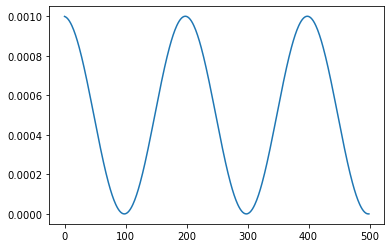

In [4]:
lr_lists = []
for i in range(500):
	lr_scheduler.step()
	lr = optimizer.param_groups[0]["lr"]
	lr_lists.append(lr)

plt.plot(lr_lists)

# Dropout

During training, some number of layer outputs are randomly ignored or “dropped out.” This has the effect of making the layer look-like and be treated-like a layer with a different number of nodes and connectivity to the prior layer. In effect, each update to a layer during training is performed with a different “view” of the configured layer.

Dropout has the effect of making the training process noisy, forcing nodes within a layer to probabilistically take on more or less responsibility for the inputs.



<img src="./img/dropout-capture.gif" alt="drawing" width="700"/>


In [ ]:

# model with Dropout
class TwoLayerNN_drop(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TwoLayerNN_drop, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=.25)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        
        # Add some dropout after first layer
        x = self.dropout(x)
        
        x = self.linear2(x)
        return torch.squeeze(x)



## Why we need Dropout?

- An unregularized network quickly overfits on the training dataset. Notice how the validation loss for without-dropout run diverges a lot after just a few epochs. This accounts for the higher generalization error. 

- Training with two dropout layers with a dropout probability of 25% prevents model from overfitting. However, this brings down the training accuracy, which means a regularized network has to be trained longer. 

- Dropout improves the model generalization. Even though the training accuracy is lower than the unregularized network, the overall validation accuracy has improved. This accounts for a lower generalization error. 



Some useful links:

- https://zhang-yang.medium.com/scaling-in-neural-network-dropout-layers-with-pytorch-code-example-11436098d426

- https://wandb.ai/authors/ayusht/reports/Dropout-in-PyTorch-An-Example--VmlldzoxNTgwOTE

# How it looks like inside ?

There're 2 steps inside the dropout

Step1: The each element in the weight matrix follow Bernouli Distribution and have `p` probability to be zero-outed. And some elements in the weight matrix will be reduced to zero like below:

<img src="./img/dropout_weights.png" alt="drawing" width="700"/>


Step2: Scaled out other non-zero elements in the weight matrix proportionally with factor of `1 / (1  - p)`

> During trraining, randomly zeroes some of the elements of the input tensor with probability `p` using samples from a Bernoulli Distribution. The elements to zeros are randomized on every forward call. And furthermore, the outputs are scaled by a factor of `1 / (1  - p)` during the training.


This essentially is saying the layer `nn.Dropout(p)` will randomly zero out the elements on the input tensor with the probability `p`, the dropout rate. The result tensor will be scaled by `1 / (1 - p)` (divied by `(1 - p)`) during the training time

Check it out: https://zhang-yang.medium.com/scaling-in-neural-network-dropout-layers-with-pytorch-code-example-11436098d426

**and Let's see an example:**

In [5]:
drop = nn.Dropout(p = 0.8)
x = torch.ones((1000, 1000))

print(x)

y = drop(x)
print(y)

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])
tensor([[5., 0., 0.,  ..., 5., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 5., 0., 0.],
        ...,
        [5., 0., 0.,  ..., 0., 0., 5.],
        [0., 0., 5.,  ..., 0., 0., 5.],
        [5., 0., 5.,  ..., 0., 0., 0.]])


In [6]:
torch.count_nonzero(y) / (1000*1000)
# we can see roughly 20% of the element in tensor are non-zeros (80% are zero-outed)
# and those 20% non-zero element would be scaled up from 1 to 5 <===> 1 / (1 - 0.8) = 5 (scaled it back )

tensor(0.2002)

# Why we need to scale the results during training?

We can explain this by having an another seneraio in evalidation.

> During the evaludation the modeule simple computes an identity functions. AKA during the evaluation time, the dropout layer will change nothing.

Because `dropout` is active only during training time but not inference time, without the scaling, the expected output would be larger during inference time because the elements are no longer being randomly dropped (set to 0). But we want the expected output with and without going through the dropout layer to be the same. Therefore, during training, we compensate by making the output of the dropout layer larger by the scaling factor of `1/(1−p)`. A larger p means more aggressive dropout, which means the more compensation we need, i.e. the larger the scaling factor `1/(1−p)`.

In other words, we we are rescaled the weights by adding extra noise without shifting the mean (mean = 0)

In [7]:
print(x.mean()) # during training before dropout

tensor(1.)


In [8]:
print(y.mean()) # during training after dropouted

tensor(1.0010)


We can see above that input x and output dropped y will be the roughly the same （这里都是training time)
因为在inference的时候我们没有做zero out这个动作，会导致inference 的tensor数值要普遍大于 training的时候

In Summary
- `model.eval()` will keep the output at the same scale.
- This basically says during evaluation/test/inference time, the dropout layer becomes an identity function and makes no change to its input.
- Dropout component is really just adding noise with mean = 0 

# **Regularization (Weight Decay)**




In [3]:
# blowing up weight decay so you can see it in action

model = nn.Sequential(nn.Linear(2, 5),
                      nn.ReLU(),
                      nn.Linear(5, 1))
optimizer = optim.SGD(model.parameters(), lr = 0.001, weight_decay = 1000.0)

In [4]:
# Before Weight Decay
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[ 0.5211,  0.4350],
        [ 0.0138, -0.3197],
        [-0.3029, -0.4422],
        [ 0.6549, -0.0485],
        [ 0.1896,  0.4058]], requires_grad=True)
Parameter containing:
tensor([ 0.3095, -0.3481,  0.5380, -0.1477,  0.6348], requires_grad=True)
Parameter containing:
tensor([[ 0.1884, -0.2489,  0.0130,  0.2549, -0.4154]], requires_grad=True)
Parameter containing:
tensor([-0.0845], requires_grad=True)


In [6]:
model.train()
y = model(torch.ones(10, 2))

# train w.r.t a loss function that wants to maximize output
(1/sum(y)).backward()
optimizer.step()

# weights have decreased
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[ 3.2645e-04,  3.2642e-04],
        [-9.3132e-10,  0.0000e+00],
        [ 0.0000e+00,  2.9802e-08],
        [ 4.4185e-04,  4.4187e-04],
        [-7.1996e-04, -7.1999e-04]], requires_grad=True)
Parameter containing:
tensor([ 3.2645e-04,  2.9802e-08,  0.0000e+00,  4.4186e-04, -7.1996e-04],
       requires_grad=True)
Parameter containing:
tensor([[ 2.1934e-03,  0.0000e+00, -9.3132e-10,  7.9492e-04,  2.1321e-03]],
       requires_grad=True)
Parameter containing:
tensor([0.0017], requires_grad=True)


---

# **Normalization**


In a deep neural network, there is a phenomenon called internal **covariate shift**, which is a change in the input distribution to the network's layers due to the ever-changing network parameters during training.
The input layer may have certain features which dominate the process, due to having high numerical values. This can create a bias in the network because only those features contribute to the outcome of the training. For example, imagine feature one having values between 1 and 5, and feature two having values between 100 and 10000. During training, due to the difference in scale of both features, feature two would dominate the network and only that feature would have a contribution to the outcome of the model.

Normalization能够解决“Internal Covariate Shift”这种问题。简单理解就是随着层数的增加，中间层的输出会发生“漂移”。另外一种说法是：BN能够解决梯度弥散。通过将输出进行适当的缩放，可以缓解梯度消失的状况。



Due to the reasons stated, a concept known as normalization was introduced to resolve these issues.


- Reducing the internal covariate shift to improve training
- Scaling each feature to a similar range to prevent or reduce bias in the network
- Speeding up the optimization process by preventing weights from exploding all over the place and limiting them to a specific range
- Reducing overfitting in the network by aiding in regularization (we must normalize before applying lasso, ridge and PCA)

# **Normalization Methods**

Ypu can check out this paper: https://arxiv.org/pdf/1803.08494.pdf


There are several flavors of normalization developed over the years, which include:

- Batch normalization
- Layer normalization
- Instance normalization
- Group normalization



<img src="./img/DL_Norm.png" alt="drawing" width="700"/>

Figure above. Normalization methods. Each subplot shows a feature map tensor, with `N` as the batch axis, `C` as the channel axis, and `(H, W)`
as the spatial axes -> `height, and width` . The pixels in blue are normalized by the same `mean` and `variance`, computed by aggregating the values of these pixels.

In NLP: `N` will be the batch axis, `C`, the Feature axis (word), and `(H, W)` will be the sentence length.

## **Batch normalization(BN)**

<img src="./img/DL_BN.png" alt="drawing" width="700"/>


In [ ]:

# model with batch normalization
class TwoLayerNN_BN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TwoLayerNN_BN, self).__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
        # we input the number of features to be normalizing across a batch
        self.bn = nn.BatchNorm1d(hidden_dim)
        
    def forward(self, x):
        x = self.linear1(x)
        
        # add batch normalization before activation
        x = self.bn(x)
        x = self.relu(x)
        
        x = self.linear2(x)
        # no batch norm for final output!
        
        return torch.squeeze(x)

## **Layer Normalization(LN)**

<img src="./img/DL_LN.png" alt="drawing" width="700"/>


https://zhuanlan.zhihu.com/p/74516930

Inspired by the results of Batch Normalization, Geoffrey Hinton et al. proposed Layer Normalization which normalizes the activations along the feature direction instead of mini-batch direction. This overcomes the cons of BN by removing the dependency on batches and makes it easier to apply for RNNs as well.

In essence, Layer Normalization normalizes each feature of the activations to zero mean and unit variance. And since many each bacth of data will contain sentences with different lengths, Layer Normalizatiob can handle it more stably than batch normalization



useful links:

1. https://zhuanlan.zhihu.com/p/74516930
2. https://arxiv.org/pdf/1803.08494.pdf
3. https://ai-pool.com/a/s/normalization-in-deep-learning


# **Early Stopping**